In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import DBUtils

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
import time as time

In [4]:
# Data loading and preprocessing into num_split number of data sets, 
# where each node will be assigned to one each
num_splits = 8

# Reproducibility
random_SEED = 42

train_fraction = 0.7
GRF_F_V_PRO_right = pd.read_csv(r'GRF_F_V_PRO_right.csv')
patient_IDs = np.unique(GRF_F_V_PRO_right['SUBJECT_ID'])

# Number of samples in the training data set
train_size = int(len(patient_IDs)*train_fraction)

patient_IDs_train, patient_IDs_test = train_test_split(patient_IDs, train_size = train_size, random_state=random_SEED)

# Create test dataset
train_set = GRF_F_V_PRO_right.loc[GRF_F_V_PRO_right['SUBJECT_ID'].isin(patient_IDs_train)]
test_set = GRF_F_V_PRO_right.loc[GRF_F_V_PRO_right['SUBJECT_ID'].isin(patient_IDs_test)]

train_set.index = pd.RangeIndex(len(train_set.index))
test_set.index = pd.RangeIndex(len(test_set.index))

# Ensure train_set is a standalone DataFrame
train_set = train_set.copy()

# Subtract mean for numeric columns from column 3 onwards
numeric_cols = train_set.iloc[:, 3:].select_dtypes(include='number')
numeric_cols = numeric_cols - numeric_cols.mean()
train_set.loc[:, train_set.columns[3:]] = numeric_cols

# Ensure train_set is a standalone DataFrame
test_set = test_set.copy()

# Subtract mean for numeric columns from column 3 onwards
numeric_cols = test_set.iloc[:, 3:].select_dtypes(include='number')
numeric_cols = numeric_cols - numeric_cols.mean()
test_set.loc[:, test_set.columns[3:]] = numeric_cols

sequence_length = test_set.iloc[:,3:].shape[1]

# Set a random seed for reproducibility
np.random.seed(random_SEED)


## Creating the num_split number of training datasets
train_datasets = []

# Create a copy of the IDs to sample from without replacement
remaining_IDs = patient_IDs_train.copy()

for i in range(num_splits):
    if i == num_splits - 1:  # For the last split, take all remaining IDs
        split = remaining_IDs
    else:
        split = np.random.choice(remaining_IDs, size=len(patient_IDs_train) // num_splits, replace=False)
        # Remove sampled IDs from remaining IDs
        remaining_IDs = np.setdiff1d(remaining_IDs, split)
    
    i_train_set = train_set.loc[train_set['SUBJECT_ID'].isin(split)]
    i_train_set.index = pd.RangeIndex(len(i_train_set.index))
    train_datasets.append(i_train_set)

In [5]:
# Defining the model
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Defining a data loader used at each node
def train_data_loader(split_index, datasets, batch_size):
    """This function creates the dataloader for each node.

    Parameters
    ----------
    split_index : (int)
        The number of the assigned node (0,1,...)
    datasets : (list)
        A list of datasets
    batch_size : (int)
        Size of the minibatch

    Returns
    -------
    A dataloader for the dataset at index split_index
    """
    train_data = datasets[split_index]
    train_data = np.array(train_data,dtype=np.float32)[:,3:]

    train_dataset = TensorDataset(torch.tensor(train_data))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return(train_dataloader)

In [6]:
## Defining the model used at each node

import os
os.makedirs('./trained_networks/example', exist_ok=True) 

numb_nodes = num_splits
input_dim = sequence_length
encoding_dim = 10
models = []
for i in range(numb_nodes):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))


In [7]:
def training(models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch):
    # Distributed training function used at each node 
    """This function creates the dataloader for each node.

    Parameters
    ----------
    models : [models]
        A list of models to be trained
    train_datasets : (list)
        A list of datasets to be used for training
    criterion : (function)
        Loss function
    num_epochs : (int)
        Number of epochs to be run
    batch_size : (int)
        Size of the minibatch
    learning_rate : (float)
        The learning rate for the optimizer
    print_epoch : (int)
        Determines if we print a loss and how often, set to 0 to omit print
    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    
    local_rank = int(os.environ["LOCAL_RANK"])
    
    model = models[local_rank]
    
    dataloader = train_data_loader(local_rank, train_datasets, batch_size)

    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(1,num_epochs+1):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # MSE between output and input

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print average loss
        if print_epoch != 0:
            if epoch % print_epoch == 0:
                print(f"Model {local_rank} Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")
    
    # Save model state in the folder ./trained_networks/example
    torch.save(model.state_dict(), "./trained_networks/example/ensemble_"+str(local_rank))

    # Attempted this, but it doesn't update the list accordingly
    models[local_rank] = model
    ##
    return 

In [8]:
# Model parameters
input_dim = sequence_length
encoding_dim = 10  # Dimension of the encoded representation

# Loss function and optimizer
criterion = nn.MSELoss()

# Parameters for the training
num_epochs = 20
batch_size = 32
learning_rate = 1e-3

# Prints the training loss every print_epoch, set to 0 to omit print
print_epoch = 10

# Import the distributor function
from pyspark.ml.torch.distributor import TorchDistributor 

In [9]:
start_time = time.time()

# run takes arguments: (<function to be run>, <arguments to be passed to function>)
TorchDistributor(num_processes=num_splits, local_mode=True, use_gpu=False).run(training, # function to run
                models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch) # arguments to pass to function

print('It took ' , time.time()-start_time ,'s')

Started local training with 8 processes
Finished local training with 8 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
Model 2 Epoch [10/20], Loss: 0.000127
Model 1 Epoch [10/20], Loss: 0.000150
Model 7 Epoch [10/20], Loss: 0.000112
Model 4 Epoch [10/20], Loss: 0.000099
Model 6 Epoch [10/20], Loss: 0.000132
Model 5 Epoch [10/20], Loss: 0.000126
Model 3 Epoch [10/20], Loss: 0.000172
Model 0 Epoch [10/20], Loss: 0.000109
Model 2 Epoch [20/20], Loss: 0.000085
Model 1 Epoch [20/20], Loss: 0.000085
Model 7 Epoch [20/20], Loss: 0.000081
Model 4 Epoch [20/20], Loss: 0.000086
Model 6 Epoch [20/20], Loss: 0.000097
Model 5 Epoch [20/20], Loss: 0.000100
Model 0 Epoch [20/20], Loss: 0.000090
Model 3 Epoch [20/20], Loss: 0.000090
It took  11.86743426322937 s


In [10]:
# Done at post-training, inference/evaluation
# Loads the trained models from the folder trained_networks/example
models = []
for i in range(numb_nodes):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))
    models[i].load_state_dict(torch.load("./trained_networks/example/ensemble_"+str(i), weights_only=True))
    models[i].eval()

In [13]:
# Use testdata to evaluate over all the nodes and average to get the mean

test_data = np.array(test_set, dtype=np.float32)[:,3:]
test_data_torch = torch.tensor(test_data)
reconstructed_per_model = []
with torch.no_grad():
    for i in range(num_splits):
        i_model = models[i]
        i_model.eval()  # Set model to evaluation mode

        reconstructed_per_model.append(i_model(test_data_torch).numpy())

    reconstructed_mean = np.array(reconstructed_per_model).mean(axis=0)
    mse_mean = criterion(torch.tensor(reconstructed_mean), test_data_torch)
    print(mse_mean)

tensor(8.0220e-05)


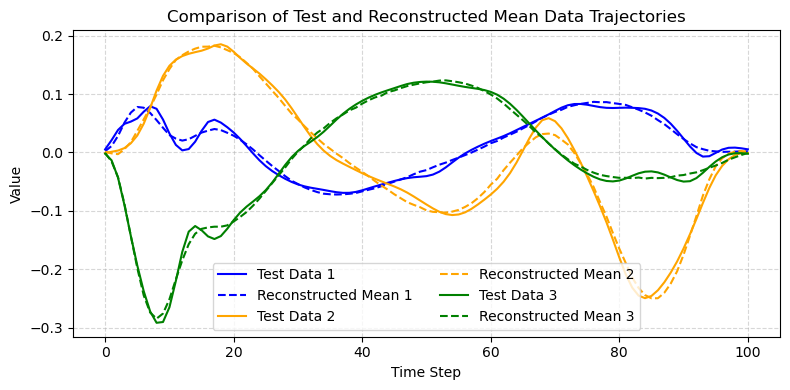

In [14]:
colors = ['blue', 'orange', 'green']

fig, axes = plt.subplots(1, 1, figsize=(8, 4))  # Create 2 subplots vertically stacked

# Plot: Test Data vs Reconstructed mean
for i, j in enumerate([333, 444, 555]):  # Plot three trajectories
    axes.plot(test_data_torch[j], label=f'Test Data {i+1}', linestyle='-', color=colors[i])
    axes.plot(reconstructed_mean[j], label=f'Reconstructed Mean {i+1}', linestyle='--', color=colors[i])

axes.set_title("Comparison of Test and Reconstructed Mean Data Trajectories")
axes.set_xlabel("Time Step")
axes.set_ylabel("Value")
axes.legend(loc='lower center', ncol=2)
axes.grid(True, linestyle='--', alpha=0.5)

# Adjust layout and show plot
plt.tight_layout()